Tutorial
========

All parts of the tutorial are presented to be run in IPython. The
required packages are only imported ones but used in all sections.

Setup
-----

First import the needed packages and modules. From the `electrode`
package, a set of electrodes form a `System`. Here, the electrodes are
either `PointPixelElectrodes` for point approximations or
`PolygonPixelElectrodes` for polygonal structures.

In [4]:
import sys

sys.path.append('../')

import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from electrode import (System, PolygonPixelElectrode, euler_matrix,
    PointPixelElectrode, PotentialObjective,
    PatternRangeConstraint, shaped)

np.set_printoptions(precision=2) # have numpy print fewer digits

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Linear surface trap
-------------------

Let's start with a very simple five-wire linear surface electrode trap.

We start with a function that returns a parametrized system of surface
electrodes. This way different designs can be compared quickly and the
design parameter space can be explored.

There ware two rf wires running along `x` with width in the `y`
direction of `top` and `bottom`. Between them, there is a long `dc`
electrode `c` of width `mid`. Above and below the rf electrodes there
are three dc electrodes `tl, tm, tr` and `bl, bm, br` to provide stray
field compensation, axial confinement and knobs to change the curvature
tensor.

In [5]:
def five_wire(edge, width, top, mid, bot):
    e, r, t, m, b = edge, width/2, top + mid/2, mid/2, -bot - mid/2
    electrodes = [
        ("tl", [[(-e, e), (-e, t), (-r, t), (-r, e)]]),
        ("tm", [[(-r, e), (-r, t), (r, t), (r, e)]]),
        ("tr", [[(r, e), (r, t), (e, t), (e, e)]]),
        ("bl", [[(-e, -e), (-r, -e), (-r, b), (-e, b)]]),
        ("bm", [[(-r, -e), (r, -e), (r, b), (-r, b)]]),
        ("br", [[(r, -e), (e, -e), (e, b), (r, b)]]),
        ("r", [[(-e, t), (-e, m), (e, m), (e, t)],
               [(-e, b), (e, b), (e, -m), (-e, -m)]]),
        ("c",  [[(-e, m), (-e, -m), (e, -m), (e, m)]]),
        ]
    s = System([PolygonPixelElectrode(name=n, paths=map(np.array, p))
                for n, p in electrodes])
    s["r"].rf = 1.
    return s

# s = System([GridElectrode.from_vtk() for n in electrodes]) wwc

Now we can retrieve such a system and plot the electrodes' shapes, and
the rf voltages on them.

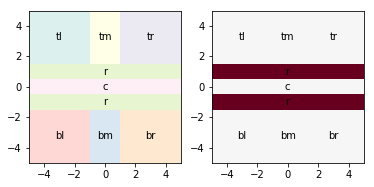

In [6]:
s = five_wire(5, 2., 1., 1., 1.)

fig, ax = plt.subplots(1, 2)
s.plot(ax[0])
s.plot_voltages(ax[1], u=s.rfs)

r = 5
for axi in ax.flat:
    axi.set_aspect("equal")
    axi.set_xlim(-r, r)
    axi.set_ylim(-r, r)

To trap an ion in this trap, we find the potential minimum in `x0` the `yz`
plane (`axis=(1, 2)`) and perform a analysis of the potential landscape
at and around this minimum assuming some typical operating parameters.
Again, we constrain the search for the minimum and the saddle point to
the `yz` plane since there is no adequate axial confinement yet.

In [7]:
l = 30e-6 # µm length scale
u = 20. # V rf peak voltage
m = 25*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
o = 2*np.pi*100e6 # rf frequency in rad/s
s["r"].rf = u*np.sqrt(q/m)/(2*l*o)
print(s["r"].rf)

x0 = s.minimum((0, 0, 1.), axis=(1, 2))

for line in s.analyze_static(x0, axis=(1,0), m=m, q=q, l=l, o=o):
    print(line)

1.04222028671137
parameters:
 f=100 MHz, m=25 amu, q=1 qe, l=30 µm, scale=0.0521 V'/V_SI
corrdinates:
 analyze point: [0.00e+00 2.28e-17 8.36e-01]
               ([0.00e+00 6.85e-16 2.51e+01] µm)
 minimum is at offset: [0. 0. 0.]
                      ([0. 0. 0.] µm)
potential:
 dc electrical: 0 eV
 rf pseudo: 1e-16 eV
 saddle offset: [1.17e-04 2.76e-05 7.21e-01]
               ([3.51e-03 8.29e-04 2.16e+01] µm)
 saddle height: 0.0099 eV
force:
 dc electrical: [0. 0. 0.] eV/l
               ([0. 0. 0.] eV/m)
 rf pseudo: [ 0.00e+00  0.00e+00 -8.48e-09] eV/l
           ([ 0.  0. -0.] eV/m)
modes:
 pp+dc normal curvatures: [1.01e-05 3.58e-01 3.62e-01]
 motion is bounded: True
 pseudopotential modes:
  a: 0.0331 MHz, [1. 0. 0.]
  b: 6.233 MHz, [0. 0. 1.]
  c: 6.267 MHz, [0. 1. 0.]
  euler angles (rzxz): [180.  90.   0.] deg
 mathieu modes:
  a: 0.03311 MHz, [ 1.00e+00 -2.24e-19 -8.82e-20]
  b: 6.272 MHz, [ 9.28e-16 -2.11e-13  9.83e-01]
  c: 6.306 MHz, [5.42e-18 9.83e-01 4.54e-18]
  euler an

The seven dc electrodes (three top, three bottom and the center wire)
can be used to apply electrical fields and electrical curvatures to
compensate stray fields and confine the ion axially.

The `shim()` method can be used to calculate voltage vectors for these
dc electrodes that are result in orthogonal effects with regards to some
cartesian partial derivatives at certain points. To use it we build a
temporary new system `s1` holding only the dc electrodes. Since these dc
electrode instances also appear in our primary system `s`, changes in
voltages are automatically synchronized between the two systems.

We then can calculate the shim voltage vectors that result in unit
changes of each of the partial derivatives `y, z, xx, xy, xz, yy, yzz` at
`x0` and plot the voltage distributions. We disturb the `x0` position slightly to 
avoid numerical problems due to the high symmetry of the trap.

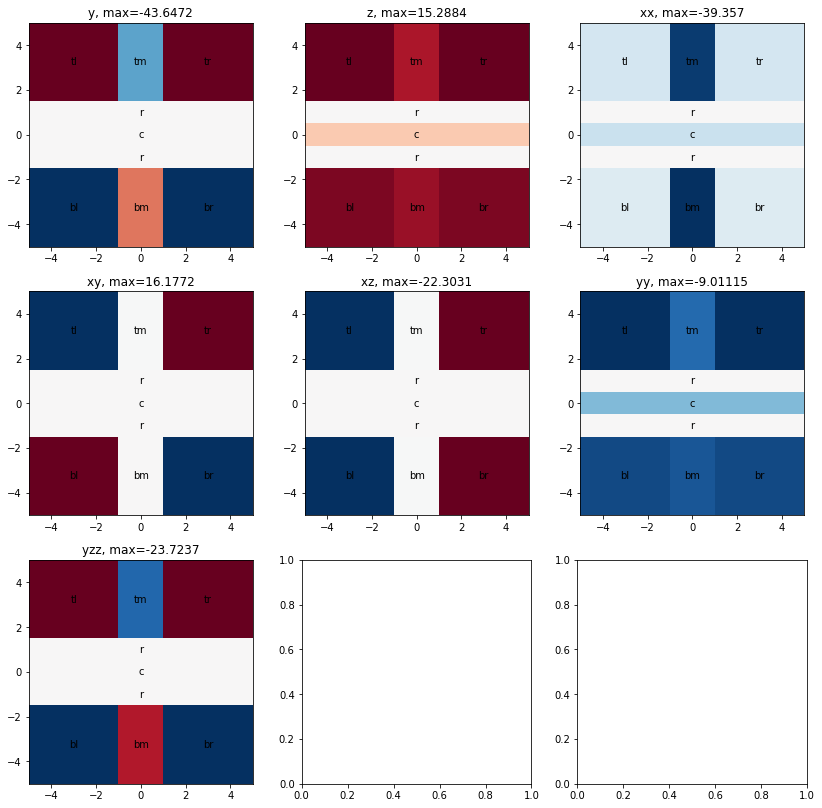

In [5]:
s1 = System([e for e in s if not e.rf])
derivs = "y z xx xy xz yy yzz".split()
u = s1.shims([(x0 + 1e-3, None, deriv) for deriv in derivs])
fig, ax = plt.subplots(3, len(derivs)//2, figsize=(14, 14))
for d, ui, axi in zip(derivs, u, ax.flat):
    with s1.with_voltages(dcs=ui):
        s.plot_voltages(axi)
        axi.set_aspect("equal")
        axi.set_xlim(-r, r)
        axi.set_ylim(-r, r)
        um = ui[np.argmax(np.fabs(ui))]
        axi.set_title("%s, max=%g" % (d, um))

Rf/dc pattern optimization
--------------------------

Define a function that generates the pixels and electrode. Here 
we return pixel electrodes with `n` pixels per unit
length in a hexagonal pattern.

If `points` is True, each pixel is approximated as a point
else each pixel is a hexagon.

In [6]:
def hextess(n, points):
    x= np.vstack([[i + j*.5, j*3**.5*.5]
        for j in range(-n - min(0, i), n - max(0, i) + 1)]
        for i in range(-n, n + 1))/(n + .5) # centers
    if points:
        a = np.ones(len(x))*3**.5/(n + .5)**2/2 # areas
        return [PointPixelElectrode(points=[xi], areas=[ai]) for
                xi, ai in zip(x, a)]
    else:
        a = 1/(3**.5*(n + .5)) # edge length
        p = x[:, None] + [[a*np.cos(phi), a*np.sin(phi)] for phi in
            np.arange(np.pi/6, 2*np.pi, np.pi/3)]
        return [PolygonPixelElectrode(paths=[i]) for i in p]

Now define a function that returns a System instance with a single hexagonal
rf pixel electrode.

The pixel factors (whether a pixel is grounded or at rf) are optimized
to yield three trapping sites forming an equilateral triangle with

  * `n` pixels per unit length,
  * trap separation `d`,
  * trap height `h` above the surface electrodes, and
  * trapping frequencies with a ratio `2:1:1` (radial being the strongest).

In [7]:
def threefold(n, h, d, points=True):
    s = System(hextess(n, points))
    ct = []
    ct.append(PatternRangeConstraint(min=0, max=1.))
    for p in 0, 4*np.pi/3, 2*np.pi/3:
        x = np.array([d/3**.5*np.cos(p), d/3**.5*np.sin(p), h])
        r = euler_matrix(p, np.pi/2, np.pi/4, "rzyz")[:3, :3]
        for i in "x y z xy xz yz".split():
            ct.append(PotentialObjective(derivative=i, x=x,
                                         rotation=r, value=0))
        for i, v in ("xx", 1), ("yy", 1):
            ct.append(PotentialObjective(derivative=i, x=x,
                                         rotation=r, value=v))
    s.rfs, c = s.optimize(ct)
    return s, c

points, n, h, d = True, 12, 1/8., 1/4.
s, c = threefold(n, h, d, points)

     pcost       dcost       gap    pres   dres   k/t
 0:  1.8926e-01 -4.9783e+02  5e+02  7e-14  3e-15  1e+00
 1:  1.5552e-01 -5.6524e+01  6e+01  8e-15  4e-15  1e-01
 2: -2.9777e-01 -2.0601e+01  2e+01  4e-14  2e-15  2e-02
 3: -4.4200e-01 -3.2442e+00  3e+00  6e-14  4e-16  3e-03
 4: -5.0508e-01 -3.0367e+00  3e+00  7e-14  5e-16  3e-03
 5: -7.9738e-01 -1.1889e+00  4e-01  2e-14  2e-16  4e-04
 6: -9.2171e-01 -1.0940e+00  2e-01  3e-14  2e-16  2e-04
 7: -9.1804e-01 -1.0767e+00  2e-01  1e-13  2e-16  2e-04
 8: -9.2821e-01 -1.0773e+00  1e-01  1e-13  2e-16  2e-04
 9: -9.4948e-01 -1.0497e+00  1e-01  8e-14  2e-16  1e-04
10: -9.8984e-01 -1.0090e+00  2e-02  2e-14  1e-16  2e-05
11: -9.9464e-01 -1.0015e+00  7e-03  5e-14  1e-16  7e-06
12: -9.9554e-01 -9.9939e-01  4e-03  5e-13  1e-16  4e-06
13: -9.9692e-01 -9.9755e-01  6e-04  1e-13  1e-16  7e-07
14: -9.9721e-01 -9.9722e-01  1e-05  3e-13  1e-16  1e-08
15: -9.9721e-01 -9.9721e-01  1e-07  1e-13  1e-16  1e-10
Optimal solution found.


Analysis of the result. `c` is the obtained strength of the constraints,
the rf field should vanish and the rf curvature should be `(2, 1, 1)`.

In [8]:
x0 = np.array([d/3**.5, 0, h])
print("c:", c)
print("rf'/c:", s.electrical_potential(x0, "rf", 1)[0]/c)
"rf''/c:", s.electrical_potential(x0, "rf", 2)[0]/c

c: 8.35200136633962
rf'/c: [-3.97e-16 -9.55e-17 -4.32e-16]


("rf''/c:", array([-2.00e+00, -4.95e-16, -6.04e-15,  1.00e+00,  7.97e-16]))

Plot the electrode pattern, white is ground, black/red is rf.

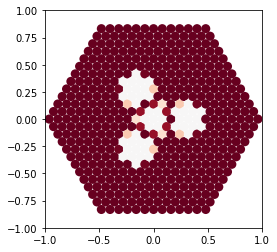

In [9]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim((-1,1))
ax.set_ylim((-1,1))
s.plot_voltages(ax, u=s.rfs)

Some textual analysis of one of the trapping sites.

In [10]:
l = 320e-6 # length scale, hexagon radius
u = 20. # peak rf voltage
o = 2*np.pi*50e6 # rf frequency
m = 24*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
s.rfs *= u*np.sqrt(q/m)/(2*l*o)

for line in s.analyze_static(x0, l=l, o=o, m=m, q=q):
    print(line)

parameters:
 f=50 MHz, m=24 amu, q=1 qe, l=320 µm, scale=0.00997 V'/V_SI
corrdinates:
 analyze point: [0.14 0.   0.12]
               ([46.19  0.   40.  ] µm)
 minimum is at offset: [0. 0. 0.]
                      ([0. 0. 0.] µm)
potential:
 dc electrical: 0 eV
 rf pseudo: 1.2e-30 eV
 saddle offset: [-0.14 -0.    0.42]
               ([-46.15  -1.4  135.72] µm)
 saddle height: 0.0064 eV
force:
 dc electrical: [0. 0. 0.] eV/l
               ([0. 0. 0.] eV/m)
 rf pseudo: [ 4.05e-15  5.78e-17 -3.12e-15] eV/l
           ([ 1.27e-11  1.81e-13 -9.75e-12] eV/m)
modes:
 pp+dc normal curvatures: [ 5.55  5.55 22.2 ]
 motion is bounded: True
 pseudopotential modes:
  a: 2.349 MHz, [-9.80e-16  9.92e-01 -1.27e-01]
  b: 2.349 MHz, [6.50e-15 1.27e-01 9.92e-01]
  c: 4.698 MHz, [ 1.00e+00  1.49e-16 -6.57e-15]
  euler angles (rzxz): [90.   90.   -7.28] deg
 mathieu modes:
  a: 2.357 MHz, [-1.17e-15 -3.49e-02  9.76e-01]
  b: 2.357 MHz, [-2.43e-16  9.80e-01  5.80e-02]
  c: 4.766 MHz, [9.61e-01 1.67e-16 1

Plot the horizontal logarithmic pseudopotential at the ion height
and the logarithmic pseudopotential and the separatrix in the xz plane.

main saddle: [ 8.09e-09 -7.25e-09  5.49e-01] 0.006427737989291602


/home/wwc/anaconda3/envs/ele36/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color'
  s)


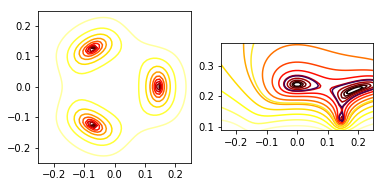

In [11]:
n = 50
xyz = np.mgrid[-d:d:1j*n, -d:d:1j*n, h:h+1]
fig, ax = plt.subplots(1, 2, subplot_kw=dict(aspect="equal"))
pot = shaped(s.potential)(xyz)
v = np.arange(-15, 3)
x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
ax[0].contour(x, y, np.log2(p), v, cmap=plt.cm.hot)

(xs1, ps1), (xs0, ps0) = s.saddle(x0+1e-2), s.saddle([0, 0, .8])
print("main saddle:", xs0, ps0)
xyz = np.mgrid[-d:d:1j*n, 0:1, .7*h:3*h:1j*n]
pot = shaped(s.potential)(xyz)
x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))
ax[1].contour(x, z, np.log2(p), v, cmap=plt.cm.hot)
ax[1].contour(x, z, np.log2(p), np.log2((ps1, ps0)), color="black")

In [12]:
import mayavi
help(mayavi)

Help on package mayavi:

NAME
    mayavi

DESCRIPTION
    A tool for easy and interactive visualization of data.
    Part of the Mayavi project of the Enthought Tool Suite.

PACKAGE CONTENTS
    __version__
    action (package)
    api
    components (package)
    core (package)
    filters (package)
    mlab
    modules (package)
    plugins (package)
    preferences (package)
    scripts (package)
    sources (package)
    tests (package)
    tools (package)
    version

DATA
    __extras_require__ = {'app': ['envisage']}
    __requires__ = ['apptools', 'envisage', 'numpy', 'pyface>=6.0.0', 'pyg...

VERSION
    4.6.1

FILE
    /home/wwc/anaconda3/envs/ele36/lib/python3.6/site-packages/mayavi/__init__.py


